In [29]:
import pandas as pd
import time

df = pd.read_csv('temperature_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

def calculate_moving_average(city_data):
    city_data = city_data.sort_values(by=['timestamp'])
    city_data['t_moving_average'] = city_data['temperature'].transform(
        lambda x: x.rolling(window=30, min_periods=1).mean()
    )
    return city_data

def calculate_seasonal_stats(city_data):
    seasonal_stats = city_data.groupby(['season']).agg(
        mean_temperature=('temperature', 'mean'),
        std_temperature=('temperature', 'std')
    ).reset_index()
    return seasonal_stats

t_start = time.time_ns()

df = df.groupby('city').apply(calculate_moving_average).reset_index(drop=True)

seasonal_stats = df.groupby('city').apply(calculate_seasonal_stats).reset_index()
df = df.merge(seasonal_stats[['city', 'season', 'mean_temperature', 'std_temperature']], on=['city', 'season'], how='left')
df['anomaly'] = (
    (df['temperature'] < df['mean_temperature'] - 2 * df['std_temperature']) |
    (df['temperature'] > df['mean_temperature'] + 2 * df['std_temperature'])
)

t_end = time.time_ns()
print('Execution time:', (t_end - t_start) / 1e6, 'ms')
df

C:\Users\redgr\AppData\Local\Temp\ipykernel_22956\2153905866.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('city').apply(calculate_moving_average).reset_index(drop=True)
C:\Users\redgr\AppData\Local\Temp\ipykernel_22956\2153905866.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_stats = df.groupby('city').apply(calculate_seasonal_stats).reset_index()


Execution time: 360.5527 ms


,city,timestamp,temperature,season,t_moving_average,mean_temperature,std_temperature,anomaly
0,Beijing,2010-01-01,-7.495140,winter,-7.495140,-1.925314,4.852838,False
1,Beijing,2010-01-02,-0.518112,winter,-4.006626,-1.925314,4.852838,False
2,Beijing,2010-01-03,0.534852,winter,-2.492800,-1.925314,4.852838,False
3,Beijing,2010-01-04,-1.803097,winter,-2.320374,-1.925314,4.852838,False
4,Beijing,2010-01-05,0.843589,winter,-1.687582,-1.925314,4.852838,False
...,...,...,...,...,...,...,...,...
54745,Tokyo,2019-12-25,17.375828,winter,8.858755,6.124267,4.881873,True
54746,Tokyo,2019-12-26,11.386471,winter,8.919919,6.124267,4.881873,False
54747,Tokyo,2019-12-27,5.951767,winter,8.722063,6.124267,4.881873,False
54748,Tokyo,2019-12-28,-0.098825,winter,8.121808,6.124267,4.881873,False


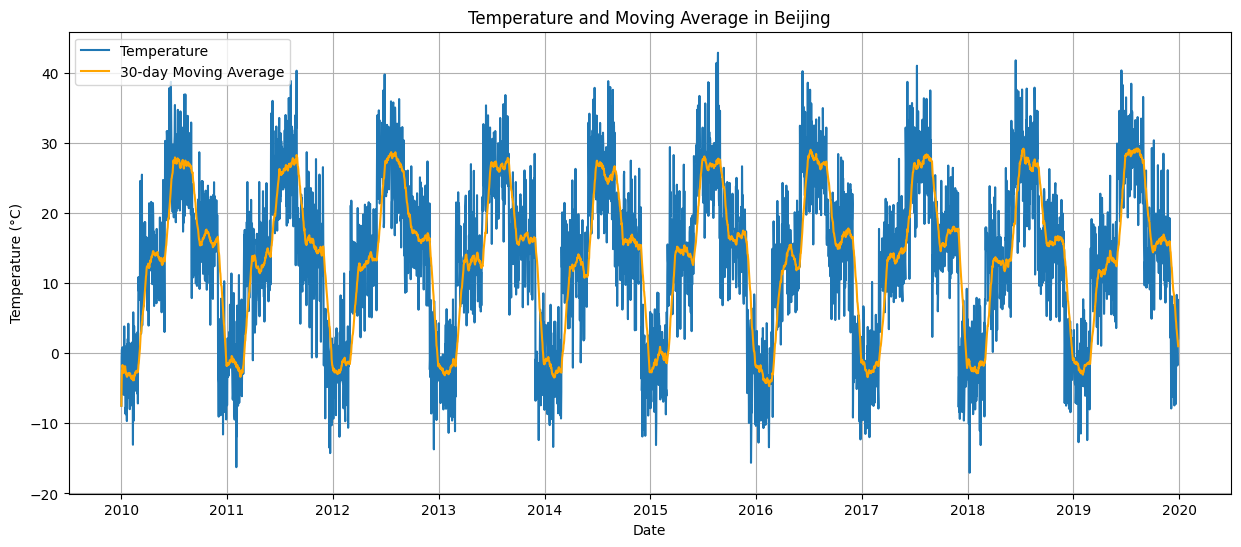

In [30]:
import matplotlib.pyplot as plt

city = df['city'].iloc[0]
city_data = df[df['city'] == city]

plt.figure(figsize=(15, 6))
plt.plot(city_data['timestamp'], city_data['temperature'], 
         label='Temperature')
plt.plot(city_data['timestamp'], city_data['t_moving_average'], 
         label='30-day Moving Average', color='orange')
plt.title(f'Temperature and Moving Average in {city}')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

In [31]:
for city in df['city'].unique():
    print(f'\ncity: {city}')
    city_data = df[df['city'] == city]
    for season in city_data['season'].unique():
        season_data = city_data[city_data['season'] == season]
        print(f'season: {season} - mean_temperature: {season_data["mean_temperature"].iloc[0]:.2f}, std_temperature: {season_data["std_temperature"].iloc[0] :.2f}')


city: Beijing
season: winter - mean_temperature: -1.93, std_temperature: 4.85
season: spring - mean_temperature: 13.14, std_temperature: 5.08
season: summer - mean_temperature: 27.13, std_temperature: 5.20
season: autumn - mean_temperature: 16.08, std_temperature: 5.10

city: Berlin
season: winter - mean_temperature: -0.18, std_temperature: 5.32
season: spring - mean_temperature: 9.99, std_temperature: 4.96
season: summer - mean_temperature: 19.94, std_temperature: 5.05
season: autumn - mean_temperature: 10.86, std_temperature: 5.02

city: Cairo
season: winter - mean_temperature: 14.45, std_temperature: 5.15
season: spring - mean_temperature: 24.78, std_temperature: 5.02
season: summer - mean_temperature: 34.84, std_temperature: 4.91
season: autumn - mean_temperature: 25.02, std_temperature: 4.98

city: Dubai
season: winter - mean_temperature: 19.71, std_temperature: 4.86
season: spring - mean_temperature: 30.06, std_temperature: 5.18
season: summer - mean_temperature: 40.29, std_temp

При использовании параллельных вычислений для анализа данных по каждому городу время выполнения увеличилась в ~10 раз. Код представлен в отдельном файле parallel_processing.py, т.к. Jupiter Notebook имеет особенности при работе с модулем multiprocessing. Замедление при распараллеливании вычислений на процессы в данном случае можно связать с тем, что создание процесса является относительно дорогостоящей операцией. Так же тратится время на передачу данных в каждый процесс через разделяемую память. Выигрыш в производительности можно было бы заметить, если бы данных для обработки было в несколько раз больше.   

In [8]:
print(df['city'].unique())

['Beijing' 'Berlin' 'Cairo' 'Dubai' 'London' 'Los Angeles' 'Mexico City'
 'Moscow' 'Mumbai' 'New York' 'Paris' 'Rio de Janeiro' 'Singapore'
 'Sydney' 'Tokyo']


In [24]:
import requests

API_KEY = ''

def get_geolocation(city):
    response = requests.get(f'http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=1&appid={API_KEY}')
    response.raise_for_status()
    first_result = response.json()[0]
    return {'lat': first_result['lat'], 'lon': first_result['lon']}

def get_current_temp(lat, lon):
    response = requests.get(f'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={API_KEY}&units=metric')
    response.raise_for_status()
    return response.json()['main']['temp']

coords = get_geolocation('Moscow')
get_current_temp(coords['lat'], coords['lon'])

-1.9

In [32]:
t_start = time.time_ns()

for city in df['city'].unique():
    print(f'\nCity: {city}')
    cur_season_data = df[(df['city'] == city) & (df['season'] == 'winter')]
    mean_temp = cur_season_data["mean_temperature"].iloc[0]
    std_temp = cur_season_data["std_temperature"].iloc[0]
    
    coords = get_geolocation(city)
    curr_temp = get_current_temp(coords['lat'], coords['lon'])
    print('Current temperature:', curr_temp)
    
    lower_bound = mean_temp - 2 * std_temp
    upper_bound = mean_temp + 2 * std_temp
    
    if lower_bound <= curr_temp <= upper_bound:
        print("Normal")
    else:
        print("Abnormal")

t_end = time.time_ns()
print('\nExecution:', (t_end - t_start) / 1e6, 'ms')


City: Beijing
Current temperature: -8.06
Normal

City: Berlin
Current temperature: 5.02
Normal

City: Cairo
Current temperature: 17.33
Normal

City: Dubai
Current temperature: 22.02
Normal

City: London
Current temperature: 6.45
Normal

City: Los Angeles
Current temperature: 15.17
Normal

City: Mexico City
Current temperature: 17.72
Normal

City: Moscow
Current temperature: -2.91
Normal

City: Mumbai
Current temperature: 25.03
Normal

City: New York
Current temperature: -6.65
Normal

City: Paris
Current temperature: 4.86
Normal

City: Rio de Janeiro
Current temperature: 25.72
Normal

City: Singapore
Current temperature: 26.69
Normal

City: Sydney
Current temperature: 21.74
Normal

City: Tokyo
Current temperature: 3.87
Normal

Execution: 15046.5288 ms


In [26]:
import aiohttp

async def get_geolocation_async(city):
    async with aiohttp.ClientSession() as session:
        async with session.get(f'http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=1&appid={API_KEY}') as response:
            response.raise_for_status()
            result = await response.json()
            first_result = result[0]
            return {'lat': first_result['lat'], 'lon': first_result['lon']}

async def get_current_temp_async(lat, lon):
    async with aiohttp.ClientSession() as session:
        async with session.get(f'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={API_KEY}&units=metric') as response:
            response.raise_for_status()
            data = await response.json()
            return data['main']['temp']

coords = await get_geolocation_async('Moscow')
await get_current_temp_async(coords['lat'], coords['lon'])

-1.9

In [33]:
import asyncio

async def get_current_weather(city):
    curr_season_data = df[(df['city'] == city) & (df['season'] == 'winter')]
    mean_temp = curr_season_data["mean_temperature"].iloc[0]
    std_temp = curr_season_data["std_temperature"].iloc[0]
    
    coords = await get_geolocation_async(city)
    curr_temp = await get_current_temp_async(coords['lat'], coords['lon'])
    
    lower_bound = mean_temp - 2 * std_temp
    upper_bound = mean_temp + 2 * std_temp
    normal = lower_bound <= curr_temp <= upper_bound
    
    return {'city': city, 'curr_temp': curr_temp, 'normal': normal}

t_start = time.time_ns()

tasks = []
for city in df['city'].unique():
    tasks.append(get_current_weather(city))

for result in await asyncio.gather(*tasks):
    print(f'\nCity: {result["city"]}\n' +
          f'Current temperature: {result["curr_temp"]}\n' +
          ('Normal' if result['normal'] else 'Abnormal'))

t_end = time.time_ns()
print('\nExecution:', (t_end - t_start) / 1e6, 'ms')


City: Beijing
Current temperature: -8.06
Normal

City: Berlin
Current temperature: 5.02
Normal

City: Cairo
Current temperature: 17.33
Normal

City: Dubai
Current temperature: 22.02
Normal

City: London
Current temperature: 6.45
Normal

City: Los Angeles
Current temperature: 15.17
Normal

City: Mexico City
Current temperature: 17.72
Normal

City: Moscow
Current temperature: -2.91
Normal

City: Mumbai
Current temperature: 25.03
Normal

City: New York
Current temperature: -6.65
Normal

City: Paris
Current temperature: 4.86
Normal

City: Rio de Janeiro
Current temperature: 25.72
Normal

City: Singapore
Current temperature: 26.69
Normal

City: Sydney
Current temperature: 21.74
Normal

City: Tokyo
Current temperature: 3.87
Normal

Execution: 1469.4394 ms


Конечно предпочтительнее использовать асинхронные методы, поскольку пока одна задача ожидает ответа от сервера API, другая может выполнить какие то вычисления и отправить свой запрос либо выполнить обработку ответа.